In [120]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import lr_scheduler
from torch.optim import lr_scheduler
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

def normalization(x: list):
    M, m = np.max(x), np.min(x)
    for i in range(len(x)):
        x[i] = (x[i] - (M + m) / 2) / ((M - m) / 2)
    # x in [-1, 1]
    return M, m, x

def ArrNorm(x: np.ndarray):
    assert isinstance(x, np.ndarray), "We need a list"
    M_list, m_list, res = [], [], []
    for i in range(x.shape[0]):
        u = x[i].tolist()
        M, m, t = normalization(u)
        res.append(t)
        M_list.append(M)
        m_list.append(m)
    return M_list, m_list, np.array(res)


def df2arr(x) -> np.ndarray:
    return np.array(x, dtype=np.float32)


In [121]:
excel = pd.read_excel('./data/A32.xlsx', header=None)
excel.shape

(4459, 18)

In [122]:
sp = [1486, 2972, 4458]
station_1 = excel.iloc[1:sp[0]+1,1:6]
station_2 = excel.iloc[sp[0]+1:sp[1]+1,1:6]
standard = excel.iloc[sp[1]+1:sp[2]+1,1:6]
standard

,1,2,3,4,5
2973,16,33,15,1.5,74
2974,16,33,15,1.7,74
2975,16,38,16,1.8,76
2976,18,41,21,1.9,79
2977,17,41,23,1.7,78
...,...,...,...,...,...
4454,16,23,49,21,99
4455,18,26,55,20.7,99
4456,19,28,52,20.8,99
4457,22,31,41,21,98


In [123]:
station_1 = df2arr(station_1)
station_2 = df2arr(station_2)
standard = df2arr(standard)
station_1.shape, station_2.shape, standard.shape

((1486, 5), (1486, 5), (1486, 5))

In [124]:
s1_minus_sd = station_1 - standard
s2_minus_sd = station_2 - standard
s1_div_sd = station_1 / standard
s2_dic_sd = station_2 / standard

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


In [125]:
s1_minus_sd.shape, s2_minus_sd.shape

((1486, 5), (1486, 5))

In [126]:
s1_minus_sd_M, s1_minus_sd_m, s1_minus_sd = ArrNorm(s1_minus_sd)

In [127]:
def GetDataset(input_arr: list, output_arr: list, seq: int):
    assert(len(input_arr)==len(output_arr)), "Different size of input and output!"
    Input = []
    Output = []
    for i in range(input_arr.shape[0]-seq):
        Input.append(input_arr[i:i+seq][:])
        Output.append(output_arr[i:i+seq][:])
    return torch.tensor(Input, dtype=torch.float32), torch.tensor(Output, dtype=torch.float32)

        
def load_array(data_arrays, batch_size, is_train=True):
    # data-iter
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

s1_minus_sd.shape

(1486, 5)

In [128]:
Input_Data_1, Output_Data_1 = GetDataset(station_1, s1_minus_sd, 15)
Input_Data_1.shape


torch.Size([1471, 15, 5])

In [129]:
Input_Data_1 = Input_Data_1.unsqueeze(1)
Output_Data_1 = Output_Data_1.unsqueeze(1)
Input_Data_1.shape, Output_Data_1.shape

(torch.Size([1471, 1, 15, 5]), torch.Size([1471, 1, 15, 5]))

In [130]:
from torch.utils.data import random_split

global cr
cr = 0.85

data_tot = torch.utils.data.TensorDataset(Input_Data_1, Output_Data_1)
train_size = int(Input_Data_1.shape[0] * cr)
test_size = Input_Data_1.shape[0] - train_size
train_set , test_set = random_split(data_tot,[train_size,test_size],
                                   torch.Generator().manual_seed(0))
# DataIter = load_array((Input_Data_1, Output_Data_1), batch_size=8)


In [131]:
global batch_size
batch_size = 8
Data_Iter = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, drop_last=True)

for i, dt in enumerate(Data_Iter):
    if dt[0].shape[0]!=batch_size:
        print(dt[0].shape)
        print(i, batch_size, dt[0].shape[0], dt)



In [132]:
# one train demo

class Try(nn.Module):
    def __init__(self, seq, batch_size, scale=0):
        super(Try, self).__init__()
        self.scale = scale
        self.seq = seq
        self.batch_size = batch_size
        self.linear = nn.Sequential(
            nn.Linear((self.seq+1)*6*5, (self.seq+1)*10),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),

            nn.Linear((self.seq+1)*10, (self.seq+1)*6),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),

        )
        self.conv1 = nn.Sequential(
            # seq * 5 
            nn.Conv2d(1, 15, kernel_size=(3,3), padding=2, bias=False), # (seq+2) * 7
            nn.BatchNorm2d(15),
            nn.ReLU(inplace=True),

            nn.Conv2d(15, 5, kernel_size=(3,3), padding=1, bias=False), # (seq+2) * 7
            nn.BatchNorm2d(5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2), stride=1), # (seq+1) * 6
            
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(1, 30, kernel_size=(2,2), padding=0, bias=False), # seq * 5
            nn.BatchNorm2d(30),
            nn.ReLU(inplace=True),

            nn.Conv2d(30, 1, kernel_size=(1,1), padding=0, bias=True), # seq * 5
            nn.ReLU(inplace=True)

        )

    def forward(self, x):
        out = self.conv1(x)
        out = out.view(out.size()[0], -1)
        out = self.linear(out)
        # print(out.shape)
        with torch.no_grad():
            out = out.reshape(self.batch_size, 1, self.seq+1, 6)
        out = self.conv2(out)      
        return out


In [159]:
def R_square(A: torch.tensor, B: torch.tensor) -> torch.float32:
    assert A.shape == B.shape, "Predict value not match the Ground Truth"
    # A: predict   B: ground truth
    # shape: batch_size * 1 * w * h
    A = A.detach()
    B = B.detach()
    A = A.squeeze()
    B = B.squeeze()
    flag = len(A.shape)==3
    # batch_size * w * h
    *_, h = A.shape
    gt_bar = torch.mean(B, dim=[0,1] if flag else 0, keepdim=False)

    def sq_sum(x):
        x = torch.tensor(x, dtype=torch.float32)
        return torch.sum(x * x, dim=[0,1] if flag else 0)
    
    SST = [sq_sum(A[:,:,i] if flag else A[:,i] - gt_bar[i]) for i in range(h)]
    SSR = [sq_sum(B[:,:,i] if flag else A[:,i] - gt_bar[i]) for i in range(h)]

    return [ (SST[i] / SSR[i]) for i in range(h) ]

"""
R-squared = SSR / SST = 1 - SSE / SST
"""
A = torch.arange(48.*2).reshape(2,1,4,12)   # test
R_square(A, A)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.)]

Start Training...


  0%|          | 0/156 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
100%|██████████| 156/156 [00:00<00:00, 284.74it/s]


[ 1|1000] 0.56(s) Train_Loss=0.071270 

100%|██████████| 156/156 [00:00<00:00, 332.10it/s]


[101|1000] 0.48(s) Train_Loss=0.071047 

100%|██████████| 156/156 [00:00<00:00, 347.91it/s]


[201|1000] 0.45(s) Train_Loss=0.071054 

100%|██████████| 156/156 [00:00<00:00, 338.56it/s]


[301|1000] 0.47(s) Train_Loss=0.071049 

100%|██████████| 156/156 [00:00<00:00, 336.30it/s]


[401|1000] 0.47(s) Train_Loss=0.071066 

100%|██████████| 156/156 [00:00<00:00, 342.35it/s]


[501|1000] 0.46(s) Train_Loss=0.071033 

100%|██████████| 156/156 [00:00<00:00, 336.29it/s]


[601|1000] 0.47(s) Train_Loss=0.071028 

100%|██████████| 156/156 [00:00<00:00, 334.21it/s]


[701|1000] 0.47(s) Train_Loss=0.071057 

100%|██████████| 156/156 [00:00<00:00, 334.50it/s]


[801|1000] 0.47(s) Train_Loss=0.071056 

100%|██████████| 156/156 [00:00<00:00, 346.67it/s]


[901|1000] 0.45(s) Train_Loss=0.071042 

100%|██████████| 156/156 [00:00<00:00, 342.21it/s]


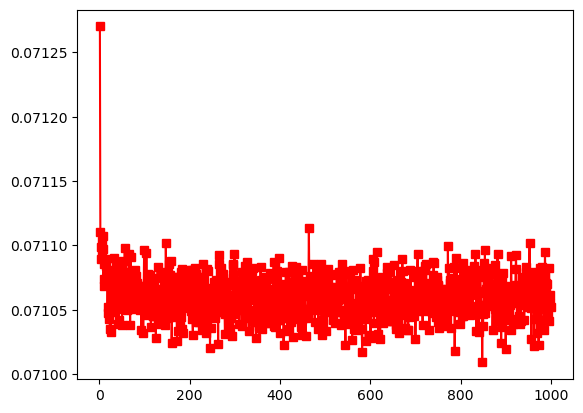

Parameters Saved.


In [137]:
x_plt, train_loss_plt = [], []
global lr, num_epoch
lr, num_epoch = 0.001, 1000


net = Try(batch_size=batch_size, seq=15).cuda()
Loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

def Iter(num_epoch):
    cnt = 0
    while cnt < num_epoch:
        yield cnt
        cnt += 1

print("Start Training...")
for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_loss = 0.0
    net.train()
    for i, use in enumerate(tqdm(Data_Iter)):
        optimizer.zero_grad()
        # if use[0].shape[0]==2:
        #     print(use[0])
        train_pred = net(use[0].cuda())    # use[0].cuda()

        batch_loss = Loss(train_pred, use[1].cuda())   # use[1].cuda()
        batch_loss.backward()
        optimizer.step()
        R2 = R_square(train_pred.cpu(), use[1].cpu())

        train_loss += batch_loss.item()

    train_loss = train_loss / train_size
    x_plt.append(epoch+1)
    train_loss_plt.append(train_loss)
    if epoch%100 == 0:
        print("[%2d|%2d] %.2f(s) Train_Loss=%.6f "%\
            (epoch+1,num_epoch,time.time()-epoch_start_time,train_loss),end='')
#         print("R-squared: ",end='')
#         R2 = torch.Tensor(R2).tolist()
#         print(R2)
    scheduler.step()  

plt.figure(1)
plt.plot(x_plt,train_loss_plt,'rs-',label='all_train_loss')
plt.show()
torch.save(net.state_dict(), './data/model_cnn.pt')
print("Parameters Saved.")

In [161]:
Test_Iter = DataLoader(dataset=test_set, batch_size=1, shuffle=False, drop_last=True)
model = Try(batch_size=1, seq=15)
model.load_state_dict(torch.load('./data/model_cnn.pt'))
model = model.cuda()
model.eval()
with torch.no_grad():
    for i, use in enumerate(Test_Iter):
        pred = model(use[0].cuda())
#         print(pred.shape, use[1].shape)
        R = R_square(pred, use[1].cuda())
        print(i, R)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0 [tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0')]
1 [tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0')]
2 [tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0')]
3 [tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0')]
4 [tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0')]
5 [tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0')]
6 [tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cud